In [1]:
import os
import time 

import gc
import torch
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

C:\Users\HP\anaconda3\envs\neural\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix 
from pathlib import Path
from tqdm import tqdm 
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision import transforms, utils, models
from skimage.io import imread
from skimage.transform import resize 

### Загрузим необходимые данные 


In [3]:
images = []
lesions = []
root = 'PH2 Dataset images/'

for d in Path(root+'PH2 Dataset images').iterdir():
    for imd in Path(d).iterdir():
        if str(imd).endswith('_Dermoscopic_Image'):
            images.append(imread(next(imd.iterdir())))
        if str(imd).endswith('_lesion'):
            lesions.append(imread(next(imd.iterdir())))

### Изображения имеют разные размеры, поэтому изменим их размер на  256×256  пикселей. Используемая функция также автоматически нормализует изображения в диапазоне  [0,1]

In [4]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Всего картинок = {len(X)}')

Всего картинок = 200


#### Визуализируем полученные данные 

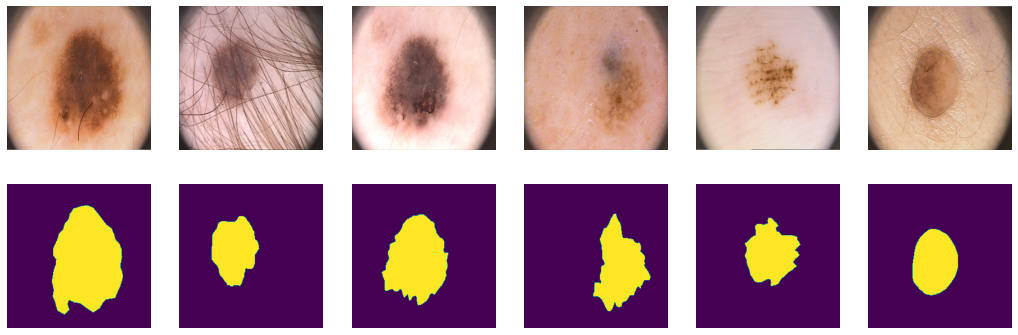

In [6]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])
    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

#### Разделим наш Dataset  на тренировочную, валидационную и тестовую выборки в случайном порядке

In [7]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

ix = np.random.choice(len(X), len(X), False)
train, valid, test = np.split(ix, [100, 150])

In [8]:
print(f'Размер train = {len(train)}, размер valid = {len(valid)}, размер test = {len(test)}') 

Размер train = 100, размер valid = 50, размер test = 50


In [9]:
batch_size = 4
data_train = DataLoader(list(zip(np.rollaxis(X[train], 3, 1), Y[train, np.newaxis])),
                        batch_size=batch_size, shuffle=True)
data_valid = DataLoader(list(zip(np.rollaxis(X[valid], 3, 1), 
                        Y[valid, np.newaxis])), 
                        batch_size=batch_size, shuffle=True)
data_test = DataLoader(list(zip(np.rollaxis(X[test], 3, 1), Y[test, np.newaxis])), 
                       batch_size=batch_size, shuffle=True)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [306]:
class EarlyStopping:
    """Класс реализующий технику раннней остановки для обученич инс"""
    def __init__(self, patience:int = 7, verbose:bool = False, delta: float = 0,
                 path:str = 'checkpoint.pt', trace_func=print):
        """
        Args:
            patience  : кол-во эпох после которых, если loss не уменьшается, обучение прекращается   
            verbose   : условие вывода сообщения для каждого улучшения loss
            delta     : минимальное изменение в контролируемом количестве, 
                        чтобы квалифицироваться как улучшение
            path      : путь к файлу для сохранения модели 
            trace_func: функция трассировки печати     
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        ''' Метод сохраняет модель при уменьшении loss'''
        if self.verbose:
            self.trace_func(f'Значение loss на валидации уменьшилось ({self.val_loss_min:.6f} -->{val_loss:.6f}).')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Приступим к реализации U-net-подобных архитектур нейронных сетей

### U-Net

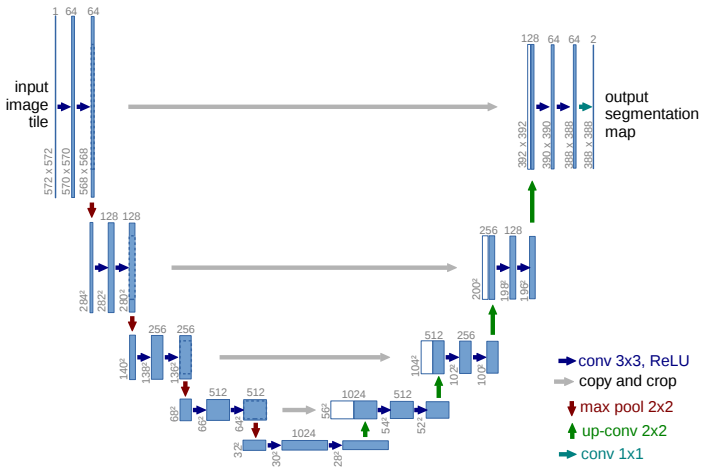

In [11]:
# Вспомогательный класс реализующий Conv + BatchNormalisation + ReLU  
class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding):
        super(conv2DBatchNormRelu, self).__init__()

        self.unit = nn.Sequential(
            nn.Conv2d(int(in_channels), int(n_filters), kernel_size=k_size, padding=padding, stride=stride),
            nn.BatchNorm2d(int(n_filters)),
            nn.ReLU(inplace=True))

    def forward(self, inputs):
        return self.unit(inputs)

In [12]:
class UNet(nn.Module):
    """ Класс реализующий архтектуру U-net сети"""
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            conv2DBatchNormRelu(3, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            conv2DBatchNormRelu(64, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            conv2DBatchNormRelu(128, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            conv2DBatchNormRelu(256, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        self.bottle_neck = nn.Sequential(
            conv2DBatchNormRelu(512, 1024, 1, 1, 0),
            conv2DBatchNormRelu(1024, 512, 1, 1, 0)   
        )

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            conv2DBatchNormRelu(512*2, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            conv2DBatchNormRelu(256*2, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            conv2DBatchNormRelu(128*2, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            conv2DBatchNormRelu(64*2, 1, 3, 1, 1),
            conv2DBatchNormRelu(1, 1, 3, 1, 1),

            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(pre_e3)        

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder
        d3 = self.dec_conv3(torch.cat([self.upsample3(bottle_neck, ind3), pre_e3], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d3, ind2), pre_e2], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d2, ind1), pre_e1], 1))
        d0 = self.dec_conv0(torch.cat([self.upsample0(d1, ind0), pre_e0], 1))

        # no activation
        return d0

In [221]:
def dice_loss(outputs: torch.Tensor, labels: torch.Tensor) -> float:
    """ Функция для вычисления значения функции потерь dice
    
    :param outputs: спрогнозированные значения
    :param labels : реальные значения 
    """
    smooth = 1e-8
    outputs = outputs.sigmoid().squeeze(1)
    labels = labels.squeeze(1)    
    i = (outputs * labels).sum()
    s = (outputs + labels).sum()
    dice = 1 - ((2. * i + smooth) / (s + smooth))
    return dice 

In [223]:
def iou(outputs: torch.Tensor, labels: torch.Tensor) -> float:
    """ Функция для вычисления значения оценочной метрики iou
    
    :param outputs     : спрогнозированные значения
    :param labels      : реальные значения
    """
    outputs = outputs.squeeze(1).byte()  
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  
    union = (outputs | labels).float().sum((1, 2))        
    iou = (intersection + SMOOTH) / (union + SMOOTH) 
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  
    
    return thresholded  

In [169]:
def dice_coeff(input, target) -> float:
    """Функция для вычисления значения оценочной метрики dice
    
    :param input : спрогнозированные значения
    :param target: реальные значения
    """
    num_in_target = input.size(0)
    smooth = 1.0
    pred = input.view(num_in_target, -1)
    truth = target.view(num_in_target, -1)
    intersection = (pred * truth).sum(1)
    loss = (2.0 * intersection + smooth) / (pred.sum(1) + truth.sum(1) + smooth)
    
    return loss.mean().item()

In [15]:
def bce(y_real, y_pred):
    return torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

In [278]:
def score_model(model, score_fn, data) -> float:
    """Функция для оценки модели
    
    :param model   : модель нейронной сети
    :param score_fn: метрика оценки
    :param data    : данные для оценивания
    """
    model.eval()  
    scores = 0
    for X_batch, Y_label in data:
        with torch.no_grad():
            Y_pred = model(X_batch.to(device))
            Y_pred = torch.ones_like(Y_pred) * (Y_pred > 0.1)
            score = score_fn(Y_pred, Y_label.to(device))
            scores += score 
    return scores/len(data)

In [274]:
def jaccard_index(pred: torch.Tensor, target: torch.Tensor) -> float:
    """ Функция для вычисления значения оценочной метрики iou
    
    :param pred  : спрогнозированные значения
    :param target: реальные значения
    
    :return значение оценочной метрики iou
    :return NaN    
    """
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = (pred.sum()+ target.sum()-intersection)
    if union == 0:
        return float("nan")
    else:
        return float(intersection) / float(max(union, 1))

In [309]:
def train_model(model, optimizer, scheduler, loss_fn, epochs, data_train, data_valid):
    '''Функция обучения модели нейронной сети
    
    :param model        : модель для обучения
    :param optimizer    : оптимизатор
    :param scheduler    : планировщик
    :param loss_fn      : функция потерь
    :param epochs       : кол-во эпох обучения
    :param data_train   : тренировочная выборка
    :param data_valid   : выборка валидации
    
    :return losses_train: массив значений loss для тренировочной выборки 
    :return losses_val  : массив значений loss для валидационной выборки
    :return scores_train: массив значений оценки для тренировочной выборки
    :return scores_val  : массив значений оценки для валидационной выборки
    '''
    gc.collect()
    torch.cuda.empty_cache()
    losses_train = []
    losses_val = []
    scores_train = []
    scores_val = []
    early_stopping = EarlyStopping(patience=5, verbose=True)

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in tqdm(data_train):
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)            
            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            optimizer.step()  # update weights
            avg_loss += loss / len(data_train)

        print('train loss: %f' % avg_loss)
        losses_train.append(avg_loss)

        avg_score_train = score_model(model, jaccard_index, data_train)
        scores_train.append(avg_score_train)
        
        avg_loss_val = 0
        model.eval() 
        for X_val, Y_val in data_valid:
            with torch.no_grad():
                Y_hat = model(X_val.to(device)).detach().cpu()# detach and put into cpu
                loss = loss_fn(Y_hat, Y_val) # forward-pass
                avg_loss_val += loss / len(data_valid)
                
        print('valid loss: %f' % avg_loss_val)
        losses_val.append(avg_loss_val)

        avg_score_val = score_model(model, jaccard_index, data_valid)
        scores_val.append(avg_score_val)
        print('valid score: %f' % avg_score_val)

        scheduler.step(avg_score_val)
        gc.collect()
        torch.cuda.empty_cache()
           
        early_stopping(avg_loss_val, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    return losses_train, losses_val, scores_train, scores_val

In [281]:
train_flag = False

def train_and_save(model, loss, name, epochs = 100, lr=0.001):
    """Функция для обучения и сохранения полученной модели нейронной сети"""
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,60], gamma=0.8)
    losses_train, losses_val, scores_train, scores_val = train_model(model, optimizer, scheduler, loss, epochs, data_train, data_valid)
    result = [losses_train, losses_val, scores_train, scores_val]
    with open(f'{name}.model', 'wb') as model_file:
        pickle.dump(model, model_file)
    with open(f'{name}.results', 'wb') as results_file:
        pickle.dump(result, results_file)
    return model, losses_train, losses_val, scores_train, scores_val

def load_results(name):
    """ Функция загрузки модели"""
    with open(f'/models/{name}.model', 'rb') as model_file:
        model = pickle.load(model_file)
    with open(f'/models/{name}.results', 'rb') as results_file:
        results = pickle.load(results_file)
    return model, results

# def train_or_load(model, loss, name, train = True):
    
#     return train_and_save(model, loss, name) if (train_flag and train) else load_results(name)

In [314]:
model_Unet = UNet()

In [301]:
model_Unet, losses_train, losses_val, scores_train, scores_val = train_and_save(model_Unet, dice_loss, 'UNet3', 50)

* Epoch 1/50


100%|██████████| 25/25 [00:13<00:00,  1.80it/s]


train loss: 0.517566
valid loss: 0.558156
valid score: 0.335494
* Epoch 2/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.477076
valid loss: 0.471702
valid score: 0.600032
* Epoch 3/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.470752
valid loss: 0.483376
valid score: 0.578730
* Epoch 4/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.467358
valid loss: 0.414188
valid score: 0.641856
* Epoch 5/50


100%|██████████| 25/25 [00:13<00:00,  1.80it/s]


train loss: 0.450549
valid loss: 0.391935
valid score: 0.623930
* Epoch 6/50


100%|██████████| 25/25 [00:13<00:00,  1.80it/s]


train loss: 0.444605
valid loss: 0.413271
valid score: 0.559907
* Epoch 7/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.438635
valid loss: 0.379929
valid score: 0.660481
* Epoch 8/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.432383
valid loss: 0.469081
valid score: 0.482640
* Epoch 9/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.422841
valid loss: 0.382801
valid score: 0.683663
* Epoch 10/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.418133
valid loss: 0.393345
valid score: 0.634236
* Epoch 11/50


100%|██████████| 25/25 [00:13<00:00,  1.80it/s]


train loss: 0.405693
valid loss: 0.367633
valid score: 0.683116
* Epoch 12/50


100%|██████████| 25/25 [00:13<00:00,  1.80it/s]


train loss: 0.395591
valid loss: 0.389500
valid score: 0.593564
* Epoch 13/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.396375
valid loss: 0.458953
valid score: 0.487498
* Epoch 14/50


100%|██████████| 25/25 [00:13<00:00,  1.80it/s]


train loss: 0.388598
valid loss: 0.349957
valid score: 0.718765
* Epoch 15/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.379661
valid loss: 0.323850
valid score: 0.731213
* Epoch 16/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.376089
valid loss: 0.345591
valid score: 0.746045
* Epoch 17/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.362853
valid loss: 0.333096
valid score: 0.750795
* Epoch 18/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.366432
valid loss: 0.383764
valid score: 0.658296
* Epoch 19/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.354653
valid loss: 0.347124
valid score: 0.714834
* Epoch 20/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.355279
valid loss: 0.321548
valid score: 0.737320
* Epoch 21/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.344330
valid loss: 0.331336
valid score: 0.761406
* Epoch 22/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.348601
valid loss: 0.341097
valid score: 0.728578
* Epoch 23/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.328006
valid loss: 0.315447
valid score: 0.755476
* Epoch 24/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.320729
valid loss: 0.324488
valid score: 0.722209
* Epoch 25/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.345323
valid loss: 0.304841
valid score: 0.773177
* Epoch 26/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.333069
valid loss: 0.303315
valid score: 0.781614
* Epoch 27/50


100%|██████████| 25/25 [00:13<00:00,  1.80it/s]


train loss: 0.321916
valid loss: 0.293554
valid score: 0.768400
* Epoch 28/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.322964
valid loss: 0.338875
valid score: 0.648983
* Epoch 29/50


100%|██████████| 25/25 [00:13<00:00,  1.80it/s]


train loss: 0.330571
valid loss: 0.306759
valid score: 0.790478
* Epoch 30/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.300182
valid loss: 0.346778
valid score: 0.668291
* Epoch 31/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.316536
valid loss: 0.296180
valid score: 0.789232
* Epoch 32/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.313790
valid loss: 0.329267
valid score: 0.718624
* Epoch 33/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.285037
valid loss: 0.272120
valid score: 0.770762
* Epoch 34/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.302605
valid loss: 0.278668
valid score: 0.766403
* Epoch 35/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.291409
valid loss: 0.289979
valid score: 0.770668
* Epoch 36/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.294761
valid loss: 0.257143
valid score: 0.794790
* Epoch 37/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.302637
valid loss: 0.323335
valid score: 0.674999
* Epoch 38/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.295640
valid loss: 0.280410
valid score: 0.764188
* Epoch 39/50


100%|██████████| 25/25 [00:13<00:00,  1.80it/s]


train loss: 0.287859
valid loss: 0.288527
valid score: 0.794571
* Epoch 40/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.282125
valid loss: 0.277042
valid score: 0.764125
* Epoch 41/50


100%|██████████| 25/25 [00:13<00:00,  1.80it/s]


train loss: 0.280124
valid loss: 0.271411
valid score: 0.795342
* Epoch 42/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.268830
valid loss: 0.241997
valid score: 0.811546
* Epoch 43/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.264297
valid loss: 0.254648
valid score: 0.777129
* Epoch 44/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.277011
valid loss: 0.279276
valid score: 0.762301
* Epoch 45/50


100%|██████████| 25/25 [00:13<00:00,  1.81it/s]


train loss: 0.270509
valid loss: 0.284023
valid score: 0.716952
* Epoch 46/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.280303
valid loss: 0.283195
valid score: 0.695853
* Epoch 47/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.262717
valid loss: 0.249314
valid score: 0.790298
* Epoch 48/50


100%|██████████| 25/25 [00:13<00:00,  1.80it/s]


train loss: 0.273301
valid loss: 0.239770
valid score: 0.802765
* Epoch 49/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.265603
valid loss: 0.270262
valid score: 0.748472
* Epoch 50/50


100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


train loss: 0.260428
valid loss: 0.246706
valid score: 0.778585


In [154]:
def plot_results(losses_train, losses_val, scores_train, scores_val):
    """Функция для построения графиков обучения модели
    
    :param losses_train : массив значений loss для тренировочной выборки
    :param losses_val   : массив значений loss для валидационной выборки
    :param scores_train : массив значений функции оценки для тренировочной выборки 
    :param scores_val   : массив значений функции оценки для валидационной выборки
    """
    plt.figure(figsize=(15, 9))
    plt.plot([i.cpu().detach().numpy() for i in losses_train], label="train_loss")
    plt.plot([i.cpu().detach().numpy() for i in losses_val], label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss/score")
    plt.show()

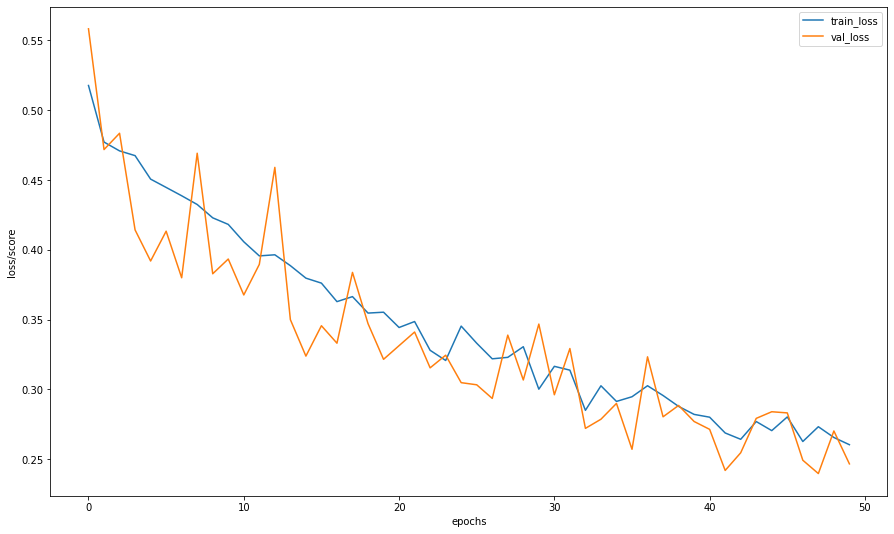

In [302]:
plot_results(losses_train, losses_val, scores_train, scores_val)

In [289]:
valid_ioc = score_model(model_Unet, jaccard_index, data_valid)
test_ioc = score_model(model_Unet, jaccard_index, data_test)
valid_dice = score_model(model_Unet, dice_coeff, data_valid)
test_dice = score_model(model_Unet, dice_coeff, data_test)
print(f'Iou valid = {valid_ioc:.3f}, Iou test = {test_ioc:.3f}')
print(f'Dice valid = {valid_dice:.3f}, Dice test = {test_dice:.3f}')

Iou valid = 0.874, Iou test = 0.869
Dice valid = 0.934, Dice test = 0.930


In [116]:
def show_segmet(model, loader):
    """Функция для визуализации работы модели"""
    model.eval()
    X_val, Y_val = next(iter(loader))
      # testing mode
    Y_hat = model(X_val.to(device)).detach().to('cpu')  # detach and put into cpu
    clear_output(wait=True)
    plt.figure(figsize=(18, 6))
    for k in range(4):
        
        plt.subplot(2, 6, k+1)
        plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        plt.imshow(Y_hat[k, 0], cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.show()

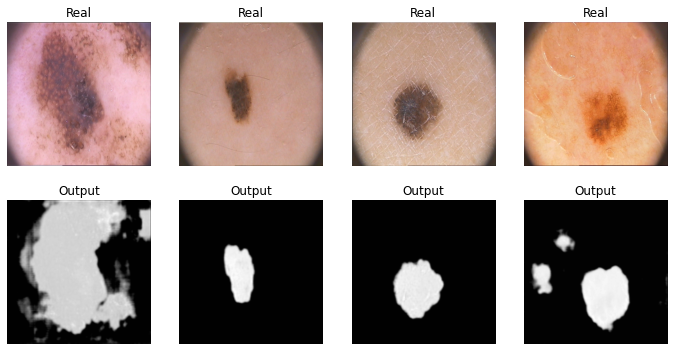

In [157]:
show_segmet(model_Unet, data_test)

### Новая модель UNet полученная путем изменения типа пулинга

In [83]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            conv2DBatchNormRelu(3, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            conv2DBatchNormRelu(64, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            conv2DBatchNormRelu(128, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            conv2DBatchNormRelu(256, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1) # 32 -> 16

        self.bottle_neck = nn.Sequential(
            conv2DBatchNormRelu(512, 1024, 1, 1, 0),
            conv2DBatchNormRelu(1024, 512, 1, 1, 0)   
        )

        self.upsample3 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            conv2DBatchNormRelu(512*2, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
        )

        self.upsample2 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            conv2DBatchNormRelu(256*2, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
        )

        self.upsample1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            conv2DBatchNormRelu(128*2, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1),
        )

        self.upsample0 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            conv2DBatchNormRelu(64*2, 1, 3, 1, 1),
            conv2DBatchNormRelu(1, 1, 3, 1, 1),

            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3 = self.pool3(pre_e3)        

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder       
        d3 = self.dec_conv3(torch.cat([self.upsample3(bottle_neck, output_size=pre_e3.size()), pre_e3], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d3, output_size=pre_e2.size()), pre_e2], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d2, output_size=pre_e1.size()), pre_e1], 1))
        d0 = self.dec_conv0(torch.cat([self.upsample0(d1, output_size=pre_e0.size()), pre_e0], 1))

        # no activation
        return d0

In [297]:
model_Unet2 = UNet2()

In [304]:
model_Unet2, losses_train2, losses_val2, scores_train2, scores_val2 = train_and_save(model_Unet2, dice_loss, 'UNet2', 100)

* Epoch 1/100


100%|██████████| 25/25 [00:18<00:00,  1.37it/s]


train loss: 0.275536
valid loss: 0.229333


C:\Users\HP\anaconda3\envs\neural\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


valid score: 0.748154
* Epoch 2/100


100%|██████████| 25/25 [00:18<00:00,  1.37it/s]


train loss: 0.238413
valid loss: 0.224666
valid score: 0.799691
* Epoch 3/100


100%|██████████| 25/25 [00:18<00:00,  1.37it/s]


train loss: 0.253210
valid loss: 0.220542
valid score: 0.784168
* Epoch 4/100


100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


train loss: 0.249804
valid loss: 0.227844
valid score: 0.782129
* Epoch 5/100


100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


train loss: 0.220363
valid loss: 0.235939
valid score: 0.763775
* Epoch 6/100


100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


train loss: 0.253856
valid loss: 0.200131
valid score: 0.782214
* Epoch 7/100


100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


train loss: 0.234129
valid loss: 0.419906
valid score: 0.456761
* Epoch 8/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.243681
valid loss: 0.211105
valid score: 0.812158
* Epoch 9/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.234539
valid loss: 0.234787
valid score: 0.785521
* Epoch 10/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.251487
valid loss: 0.277119
valid score: 0.680783
* Epoch 11/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.222207
valid loss: 0.210688
valid score: 0.786455
* Epoch 12/100


100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


train loss: 0.227657
valid loss: 0.230888
valid score: 0.752996
* Epoch 13/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.225954
valid loss: 0.361588
valid score: 0.530955
* Epoch 14/100


100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


train loss: 0.211099
valid loss: 0.206016
valid score: 0.780646
* Epoch 15/100


100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


train loss: 0.217329
valid loss: 0.217985
valid score: 0.812321
* Epoch 16/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.186865
valid loss: 0.191912
valid score: 0.798346
* Epoch 17/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.232620
valid loss: 0.226943
valid score: 0.790333
* Epoch 18/100


100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


train loss: 0.206612
valid loss: 0.202399
valid score: 0.810295
* Epoch 19/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.209658
valid loss: 0.205646
valid score: 0.820799
* Epoch 20/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.209692
valid loss: 0.204192
valid score: 0.797111
* Epoch 21/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.207491
valid loss: 0.188433
valid score: 0.808629
* Epoch 22/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.208660
valid loss: 0.186645
valid score: 0.774458
* Epoch 23/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.191838
valid loss: 0.185391
valid score: 0.805530
* Epoch 24/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.198158
valid loss: 0.234094
valid score: 0.695452
* Epoch 25/100


100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


train loss: 0.179601
valid loss: 0.168567
valid score: 0.828711
* Epoch 26/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.197652
valid loss: 0.200578
valid score: 0.794798
* Epoch 27/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.190629
valid loss: 0.182708
valid score: 0.772356
* Epoch 28/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.182044
valid loss: 0.186392
valid score: 0.789012
* Epoch 29/100


100%|██████████| 25/25 [00:18<00:00,  1.34it/s]


train loss: 0.190695
valid loss: 0.201674
valid score: 0.740408
* Epoch 30/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.193652
valid loss: 0.188185
valid score: 0.806486
* Epoch 31/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.206814
valid loss: 0.230883
valid score: 0.663005
* Epoch 32/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.180081
valid loss: 0.180789
valid score: 0.785252
* Epoch 33/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.188151
valid loss: 0.188467
valid score: 0.812955
* Epoch 34/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.176173
valid loss: 0.173415
valid score: 0.800853
* Epoch 35/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.188938
valid loss: 0.223951
valid score: 0.734080
* Epoch 36/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.196966
valid loss: 0.157282
valid score: 0.813320
* Epoch 37/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.162453
valid loss: 0.185405
valid score: 0.786158
* Epoch 38/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.175255
valid loss: 0.171408
valid score: 0.820560
* Epoch 39/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.181857
valid loss: 0.200306
valid score: 0.787430
* Epoch 40/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.173765
valid loss: 0.166778
valid score: 0.811750
* Epoch 41/100


100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


train loss: 0.169778
valid loss: 0.224160
valid score: 0.718128
* Epoch 42/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.167178
valid loss: 0.179204
valid score: 0.796318
* Epoch 43/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.160717
valid loss: 0.191989
valid score: 0.784745
* Epoch 44/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.164689
valid loss: 0.173939
valid score: 0.812047
* Epoch 45/100


100%|██████████| 25/25 [00:18<00:00,  1.37it/s]


train loss: 0.153260
valid loss: 0.188114
valid score: 0.774263
* Epoch 46/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.165141
valid loss: 0.155914
valid score: 0.841192
* Epoch 47/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.172027
valid loss: 0.168704
valid score: 0.815408
* Epoch 48/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.162184
valid loss: 0.300818
valid score: 0.585926
* Epoch 49/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.166715
valid loss: 0.163171
valid score: 0.794867
* Epoch 50/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.166645
valid loss: 0.151616
valid score: 0.811614
* Epoch 51/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.152246
valid loss: 0.154264
valid score: 0.846835
* Epoch 52/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.146153
valid loss: 0.152292
valid score: 0.830878
* Epoch 53/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.160044
valid loss: 0.158684
valid score: 0.805570
* Epoch 54/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.156793
valid loss: 0.164986
valid score: 0.788955
* Epoch 55/100


100%|██████████| 25/25 [00:18<00:00,  1.34it/s]


train loss: 0.143233
valid loss: 0.141865
valid score: 0.840416
* Epoch 56/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.165058
valid loss: 0.160410
valid score: 0.796922
* Epoch 57/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.157379
valid loss: 0.153978
valid score: 0.794445
* Epoch 58/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.148684
valid loss: 0.144388
valid score: 0.830467
* Epoch 59/100


100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


train loss: 0.149649
valid loss: 0.143391
valid score: 0.819596
* Epoch 60/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.143243
valid loss: 0.139629
valid score: 0.807399
* Epoch 61/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.151593
valid loss: 0.152355
valid score: 0.796008
* Epoch 62/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.156638
valid loss: 0.141098
valid score: 0.828189
* Epoch 63/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.134377
valid loss: 0.126228
valid score: 0.860019
* Epoch 64/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.131235
valid loss: 0.128914
valid score: 0.838543
* Epoch 65/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.134787
valid loss: 0.145529
valid score: 0.830690
* Epoch 66/100


100%|██████████| 25/25 [00:18<00:00,  1.34it/s]


train loss: 0.147030
valid loss: 0.154175
valid score: 0.808221
* Epoch 67/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.141828
valid loss: 0.147708
valid score: 0.813764
* Epoch 68/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.135139
valid loss: 0.154110
valid score: 0.806078
* Epoch 69/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.147545
valid loss: 0.124665
valid score: 0.851551
* Epoch 70/100


100%|██████████| 25/25 [00:18<00:00,  1.34it/s]


train loss: 0.129419
valid loss: 0.127273
valid score: 0.848647
* Epoch 71/100


100%|██████████| 25/25 [00:18<00:00,  1.34it/s]


train loss: 0.121858
valid loss: 0.137334
valid score: 0.824067
* Epoch 72/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.135178
valid loss: 0.139928
valid score: 0.828931
* Epoch 73/100


100%|██████████| 25/25 [00:18<00:00,  1.34it/s]


train loss: 0.138100
valid loss: 0.131839
valid score: 0.853970
* Epoch 74/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.138885
valid loss: 0.159294
valid score: 0.788941
* Epoch 75/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.137710
valid loss: 0.168490
valid score: 0.772135
* Epoch 76/100


100%|██████████| 25/25 [00:18<00:00,  1.34it/s]


train loss: 0.134573
valid loss: 0.117736
valid score: 0.853080
* Epoch 77/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.137051
valid loss: 0.122954
valid score: 0.854722
* Epoch 78/100


100%|██████████| 25/25 [00:18<00:00,  1.34it/s]


train loss: 0.125177
valid loss: 0.180590
valid score: 0.759782
* Epoch 79/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.126804
valid loss: 0.133618
valid score: 0.827549
* Epoch 80/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.111303
valid loss: 0.114709
valid score: 0.855628
* Epoch 81/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.122582
valid loss: 0.120232
valid score: 0.863441
* Epoch 82/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.127192
valid loss: 0.137840
valid score: 0.818870
* Epoch 83/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.123905
valid loss: 0.134875
valid score: 0.824987
* Epoch 84/100


100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


train loss: 0.118719
valid loss: 0.118148
valid score: 0.851116
* Epoch 85/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.132606
valid loss: 0.120316
valid score: 0.852515
* Epoch 86/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.106410
valid loss: 0.147949
valid score: 0.801149
* Epoch 87/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.122583
valid loss: 0.134223
valid score: 0.846277
* Epoch 88/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.154541
valid loss: 0.203419
valid score: 0.739600
* Epoch 89/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.112047
valid loss: 0.110216
valid score: 0.863178
* Epoch 90/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.112727
valid loss: 0.131234
valid score: 0.830017
* Epoch 91/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.106909
valid loss: 0.108426
valid score: 0.858021
* Epoch 92/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.105008
valid loss: 0.137426
valid score: 0.831160
* Epoch 93/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.109899
valid loss: 0.117330
valid score: 0.841013
* Epoch 94/100


100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


train loss: 0.124946
valid loss: 0.285640
valid score: 0.597109
* Epoch 95/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.128013
valid loss: 0.127530
valid score: 0.835954
* Epoch 96/100


100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


train loss: 0.114515
valid loss: 0.108352
valid score: 0.850960
* Epoch 97/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.109575
valid loss: 0.119973
valid score: 0.850955
* Epoch 98/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.109397
valid loss: 0.119619
valid score: 0.828677
* Epoch 99/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.123268
valid loss: 0.109722
valid score: 0.849403
* Epoch 100/100


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


train loss: 0.103304
valid loss: 0.101953
valid score: 0.846105


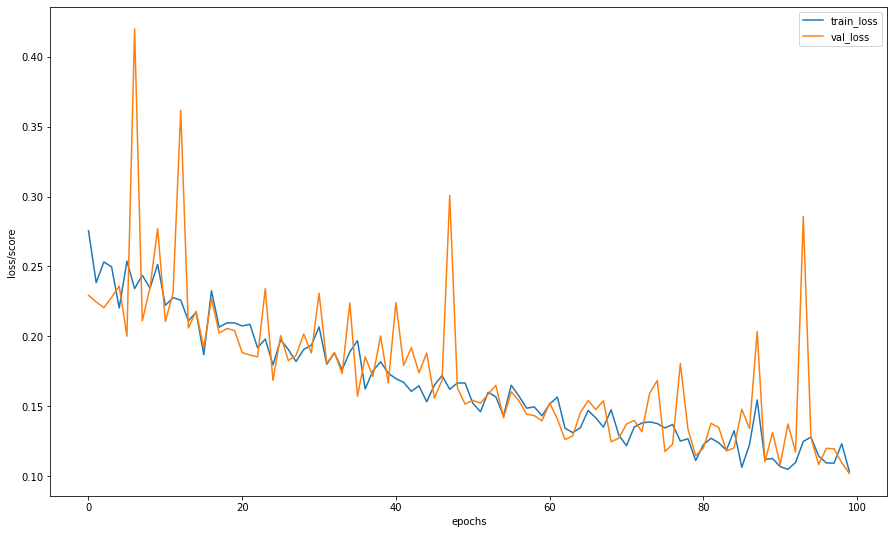

In [305]:
plot_results(losses_train2, losses_val2, scores_train2, scores_val2) 

In [317]:
gc.collect()
torch.cuda.empty_cache()

In [318]:
valid_ioc = score_model(model_Unet2, jaccard_index, data_valid)
test_ioc = score_model(model_Unet2, jaccard_index, data_test)
valid_dice = score_model(model_Unet2, dice_coeff, data_valid)
test_dice = score_model(model_Unet2, dice_coeff, data_test)
print(f'Iou valid = {valid_ioc:.3f}, Iou test = {test_ioc:.3f}')
print(f'Dice valid = {valid_dice:.3f}, Dice test = {test_dice:.3f}')

Iou valid = 0.806, Iou test = 0.815
Dice valid = 0.889, Dice test = 0.883


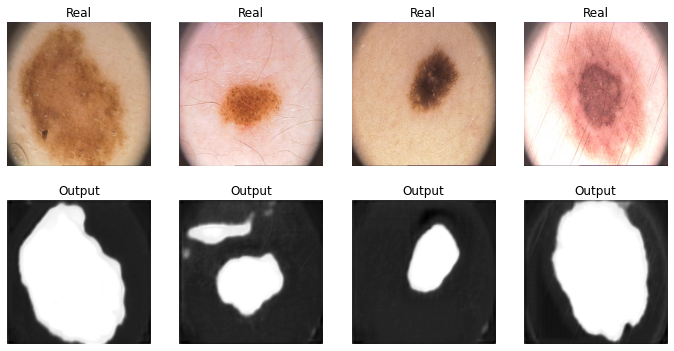

In [118]:
show_segmet(model_Unet2, data_test)

### SegNet

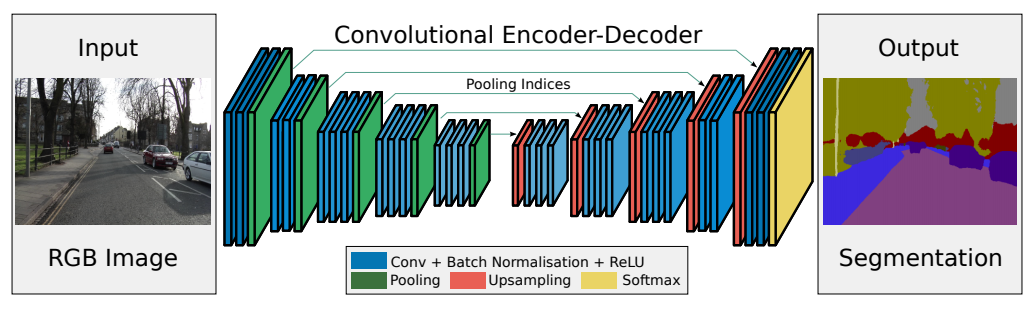

In [119]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            conv2DBatchNormRelu(3, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            conv2DBatchNormRelu(64, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            conv2DBatchNormRelu(128, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            conv2DBatchNormRelu(256, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16
        # bottleneck
        self.bottle_neck = nn.Sequential(
            conv2DBatchNormRelu(512, 1024, 1, 1, 0),
            conv2DBatchNormRelu(1024, 512, 1, 1, 0)   
        )

        # decoder (upsampling)
        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            conv2DBatchNormRelu(512, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            conv2DBatchNormRelu(256, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            conv2DBatchNormRelu(128, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            conv2DBatchNormRelu(64, 1, 3, 1, 1),
            conv2DBatchNormRelu(1, 1, 3, 1, 1),

            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))        

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder
        d3 = self.dec_conv3(self.upsample3(bottle_neck, ind3))
        d2 = self.dec_conv2(self.upsample2(d3, ind2))
        d1 = self.dec_conv1(self.upsample1(d2, ind1))
        d0 = self.dec_conv0(self.upsample0(d1, ind0))

        # no activation
        return d0

In [122]:
model_segnet = SegNet()

In [129]:
model_segnet, losses_train3, losses_val3, scores_train3, scores_val3 = train_and_save(model_segnet, dice_loss, 'SegNet', 30)

* Epoch 1/30


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


train loss: 0.160524
valid loss: 0.237818


C:\Users\HP\anaconda3\envs\neural\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


valid score: 0.461538
* Epoch 2/30


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


train loss: 0.167414
valid loss: 0.153941
valid score: 0.690385
* Epoch 3/30


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


train loss: 0.161405
valid loss: 0.150233
valid score: 0.726923
* Epoch 4/30


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


train loss: 0.141009
valid loss: 0.158777
valid score: 0.721154
* Epoch 5/30


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


train loss: 0.148699
valid loss: 0.157926
valid score: 0.692308
* Epoch 6/30


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


train loss: 0.139474
valid loss: 0.164918
valid score: 0.675000
* Epoch 7/30


100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


train loss: 0.146592
valid loss: 0.149450
valid score: 0.719231
* Epoch 8/30


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


train loss: 0.148952
valid loss: 0.157988
valid score: 0.686538
* Epoch 9/30


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


train loss: 0.138192
valid loss: 0.151812
valid score: 0.723077
* Epoch 10/30


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


train loss: 0.133446
valid loss: 0.155478
valid score: 0.703846
* Epoch 11/30


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


train loss: 0.135418
valid loss: 0.149515
valid score: 0.684615
* Epoch 12/30


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


train loss: 0.157047
valid loss: 0.149327
valid score: 0.715385
* Epoch 13/30


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


train loss: 0.130975
valid loss: 0.144732
valid score: 0.703846
* Epoch 14/30


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


train loss: 0.134369
valid loss: 0.148935
valid score: 0.694231
* Epoch 15/30


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


train loss: 0.132134
valid loss: 0.136562
valid score: 0.736538
* Epoch 16/30


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


train loss: 0.140211
valid loss: 0.156928
valid score: 0.659615
* Epoch 17/30


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


train loss: 0.137950
valid loss: 0.141380
valid score: 0.726923
* Epoch 18/30


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


train loss: 0.119802
valid loss: 0.133744
valid score: 0.732692
* Epoch 19/30


100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


train loss: 0.118338
valid loss: 0.135129
valid score: 0.715385
* Epoch 20/30


100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


train loss: 0.125750
valid loss: 0.131019
valid score: 0.748077
* Epoch 21/30


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


train loss: 0.131525
valid loss: 0.143776
valid score: 0.703846
* Epoch 22/30


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


train loss: 0.114827
valid loss: 0.139986
valid score: 0.717308
* Epoch 23/30


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


train loss: 0.121673
valid loss: 0.131009
valid score: 0.746154
* Epoch 24/30


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


train loss: 0.119265
valid loss: 0.144413
valid score: 0.736538
* Epoch 25/30


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


train loss: 0.111116
valid loss: 0.134647
valid score: 0.732692
* Epoch 26/30


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


train loss: 0.112374
valid loss: 0.128145
valid score: 0.721154
* Epoch 27/30


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


train loss: 0.123701
valid loss: 0.141710
valid score: 0.696154
* Epoch 28/30


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


train loss: 0.114709
valid loss: 0.134870
valid score: 0.734615
* Epoch 29/30


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


train loss: 0.099644
valid loss: 0.131586
valid score: 0.730769
* Epoch 30/30


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


train loss: 0.114226
valid loss: 0.134449
valid score: 0.688462


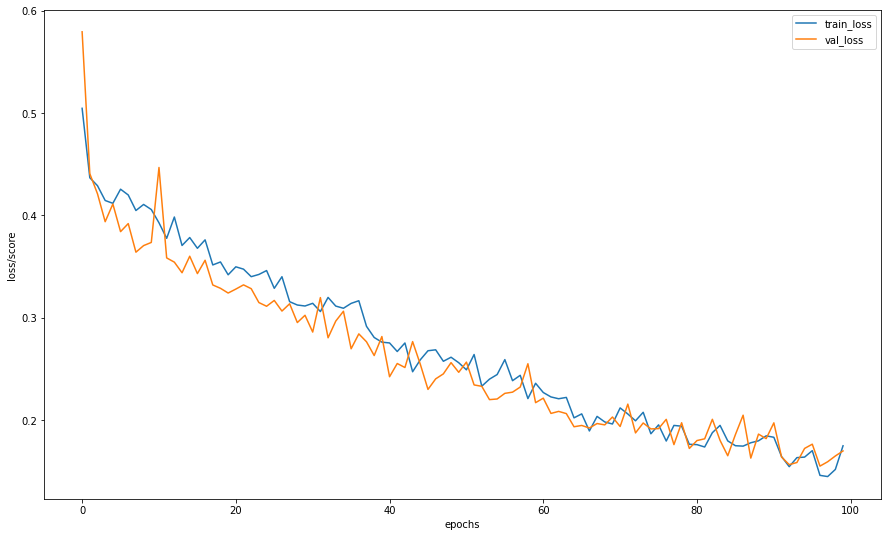

In [124]:
plot_results(losses_train3, losses_val3, scores_train3, scores_val3) 

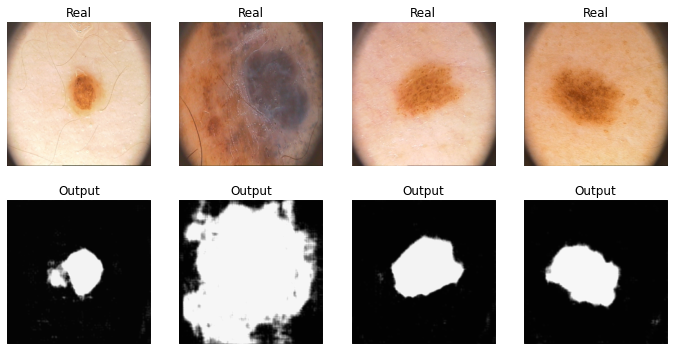

In [138]:
show_segmet(model_segnet, data_test)

In [291]:
valid_ioc = score_model(model_segnet, jaccard_index, data_valid)
test_ioc = score_model(model_segnet, jaccard_index, data_test)
valid_dice = score_model(model_segnet, dice_coeff, data_valid)
test_dice = score_model(model_segnet, dice_coeff, data_test)
print(f'Iou valid = {valid_ioc:.3f}, Iou test = {test_ioc:.3f}')
print(f'Dice valid = {valid_dice:.3f}, Dice test = {test_dice:.3f}')

Iou valid = 0.819, Iou test = 0.806
Dice valid = 0.897, Dice test = 0.896
